In [1]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from keras.layers import Dense
from keras.models import load_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.applications import DenseNet121
from keras.applications.densenet import preprocess_input
from keras.metrics import binary_accuracy
from keras.preprocessing import image

from keras.models import Model

from keras.optimizers import Adam
from keras.optimizers import AdamW
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# Import Densenet from Keras
from keras.applications.densenet import DenseNet121
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K
import warnings
warnings.filterwarnings("ignore")

2024-08-24 11:00:03.086597: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-24 11:00:03.086697: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-24 11:00:03.223388: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema',
          'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass','Hernia']

In [3]:
train_df = pd.read_csv('/kaggle/input/datasetcsv/train.csv')
val_df = pd.read_csv('/kaggle/input/datasetcsv/validation.csv')
test_df = pd.read_csv('/kaggle/input/datasetcsv/test.csv')

In [4]:
print('train', train_df.shape[0],'vald:',val_df.shape[0], 'test:', test_df.shape[0])

train 79893 vald: 8654 test: 23573


In [5]:
# Define the mean and standard deviation values for normalization using ImageNet values
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Define a custom preprocessing function to normalize the image
def preprocess_image(img):
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(2, 2))
    #img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # Apply CLAHE to the image
    #claheimage = clahe.apply(img)
    img = img / 255.0
    img = (img - mean) / std
    return img


horizontal_flip=True, 
    vertical_flip=True, 
    height_shift_range=0.1, 
    width_shift_range=0.1,
    channel_shift_range=20,
    brightness_range=[0.2, 1],
    rotation_range=10, 
    shear_range=0.1,
    fill_mode='reflect',
    zoom_range=0.1,    

In [7]:
train_generator = ImageDataGenerator(
    samplewise_center=False, 
    samplewise_std_normalization=False, 
    horizontal_flip=True, 
    height_shift_range=0.1, 
    width_shift_range=0.05,
    rotation_range=5, 
    shear_range=0.1,
    zoom_range=0.05,    
    preprocessing_function=preprocess_image
).flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='full_path',
    y_col=labels,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=64
)

Found 79893 validated image filenames.


In [8]:
val_generator = ImageDataGenerator(
    preprocessing_function=preprocess_image
).flow_from_dataframe(
    dataframe=val_df,
    directory=None,
    x_col='full_path',
    y_col=labels,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=64
)

Found 8654 validated image filenames.


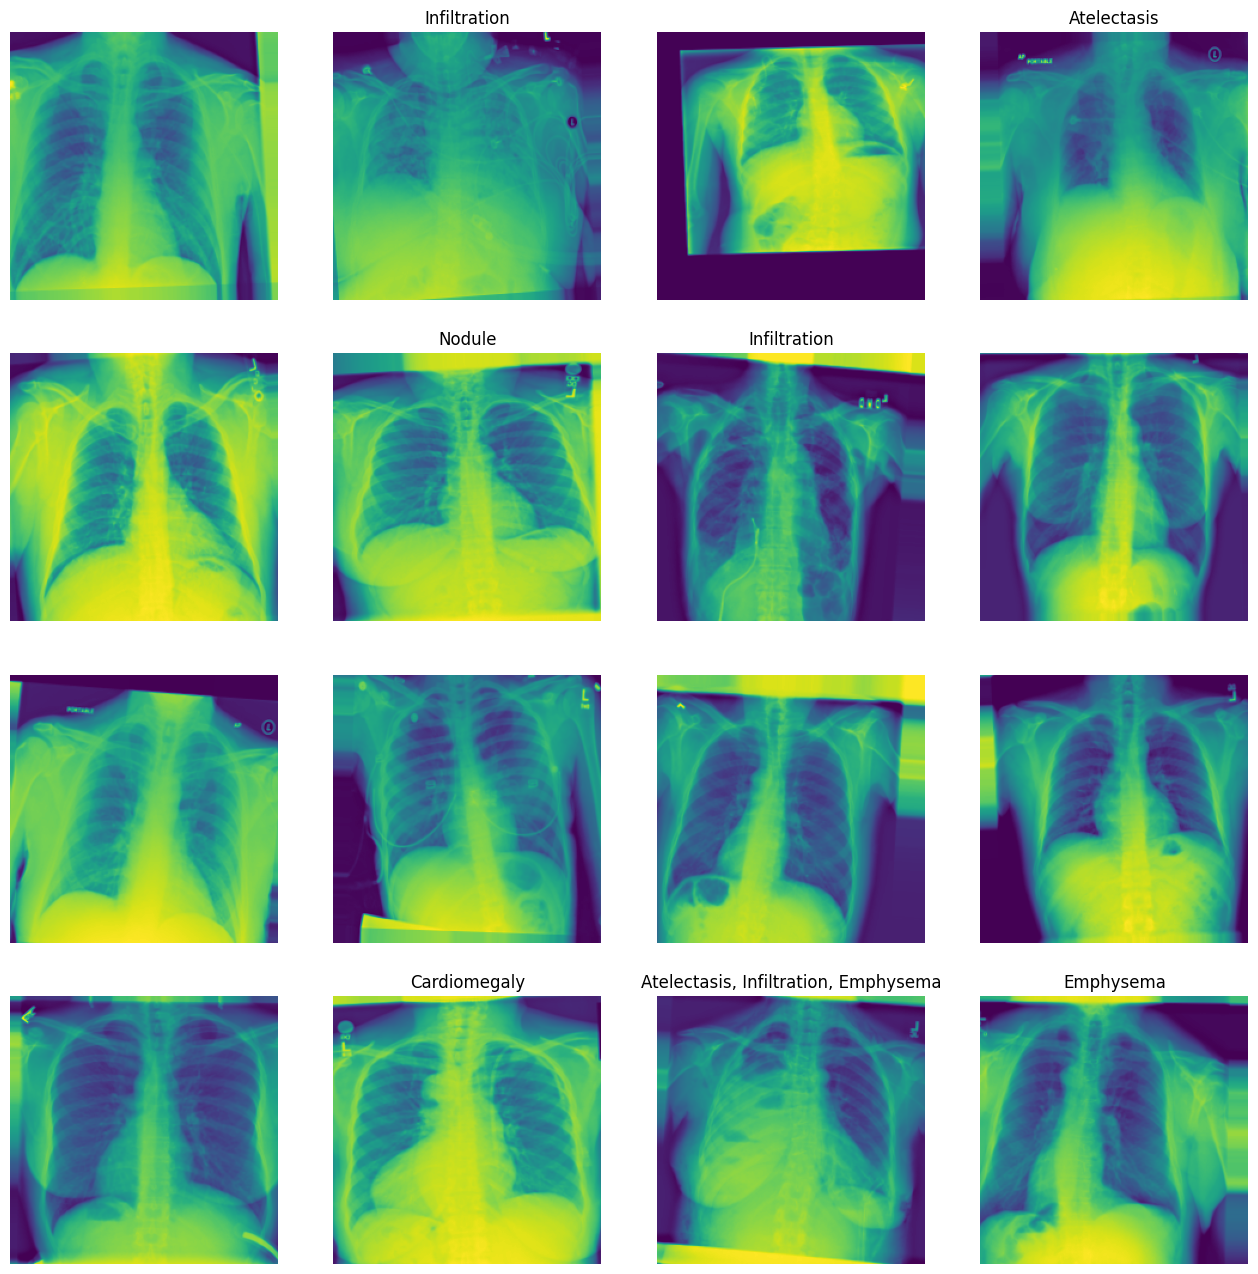

In [9]:
t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0])
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

In [10]:
from keras.applications import DenseNet121
from keras.optimizers import Adamax
from tensorflow.keras.metrics import AUC

def build_model():
    # Load the pre-trained DenseNet121 model
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')

    # Add new trainable layers on top of the pre-trained model
    x = base_model.output

    preds = Dense(len(labels), activation='sigmoid')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=preds)
    # Create an Adam optimizer with weight decay
    optimizer = Adamax(learning_rate=1e-3)
    model.compile(optimizer=optimizer ,loss='binary_crossentropy',metrics=['binary_accuracy','AUC']) 
    return model
    #model.summary()

In [11]:
import tensorflow as tf

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


In [12]:
# buiding a model inside the strategy scope
with strategy.scope():
    multi_gpu_model = build_model()
#multi_gpu_model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
import os
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
checkpoint_path_val_loss = 'model/DenseNet121_val_loss.keras'
checkpoint_path_val_AUC= 'model/DenseNet121_val_AUC.keras'
checkpoint_path_train_loss='model/DenseNet121_train_loss.keras'
checkpoint_path_train_AUC= 'model/DenseNet121_train_AUC.keras'

checkpoint_path_train_accuracy= 'model/DenseNet121_train_accuracy.keras'
checkpoint_path_val_accuracy= 'model/DenseNet121_val_accuracy.keras'

checkpoint_dir = os.path.dirname(checkpoint_path_val_loss)


# Define the ReduceLROnPlateau & ModelCheckpoint & Early stopping callbacks
checkpoint_val_accuracy = ModelCheckpoint(checkpoint_path_train_accuracy, verbose=0, monitor='val_accuracy', save_best_only=True, mode='max')
checkpoint_train_accuracy = ModelCheckpoint(checkpoint_path_val_accuracy, verbose=0, monitor='val_binary_accuracy', save_best_only=True, mode='max')

checkpoint_val_loss = ModelCheckpoint(checkpoint_path_val_loss, verbose=0, save_best_only=True)
checkpoint_val_AUC = ModelCheckpoint(checkpoint_path_val_AUC, verbose=0, save_best_only=True, monitor='val_AUC', mode='max')

checkpoint_train_AUC= ModelCheckpoint(checkpoint_path_train_AUC, verbose=0, save_best_only=True, monitor='val_AUC', mode='max')
checkpoint_train_loss = ModelCheckpoint(checkpoint_path_train_loss, verbose=0,monitor='loss', mode='min', save_best_only=True)
anne = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='max')


In [14]:
# Train the model using the generator
history = multi_gpu_model.fit(
    train_generator,
    epochs=30,
    #steps_per_epoch=100,
    callbacks=[anne,
               checkpoint_val_loss, checkpoint_val_AUC,
               checkpoint_train_loss, checkpoint_train_AUC,
               checkpoint_val_accuracy, checkpoint_train_accuracy ],

    validation_data=val_generator,
)

Epoch 1/30
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 1869s 1s/step - AUC: 0.7941 - binary_accuracy: 0.9438 - loss: 0.1786 - val_AUC: 0.8395 - val_binary_accuracy: 0.9494 - val_loss: 0.1620 - learning_rate: 0.0010
Epoch 2/30
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 1398s 1s/step - AUC: 0.8467 - binary_accuracy: 0.9495 - loss: 0.1566 - val_AUC: 0.8405 - val_binary_accuracy: 0.9491 - val_loss: 0.1602 - learning_rate: 0.0010
Epoch 3/30
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 1381s 1s/step - AUC: 0.8575 - binary_accuracy: 0.9489 - loss: 0.1546 - val_AUC: 0.8497 - val_binary_accuracy: 0.9497 - val_loss: 0.1557 - learning_rate: 0.0010
Epoch 4/30
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 1378s 1s/step - AUC: 0.8644 - binary_accuracy: 0.9491 - loss: 0.1520 - val_AUC: 0.8504 - val_binary_accuracy: 0.9490 - val_loss: 0.1574 - learning_rate: 0.0010
Epoch 5/30
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 1387s 1s/step - AUC: 0.8681 - binary_accuracy: 0.9494 - loss: 0.1504 - val_AUC: 0.8634 - val_binary_accuracy: 0.9480 - val_loss: 0.1536 - learning_rat

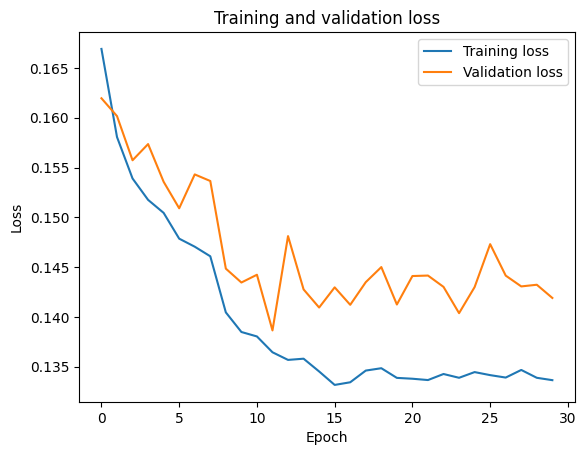

In [15]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

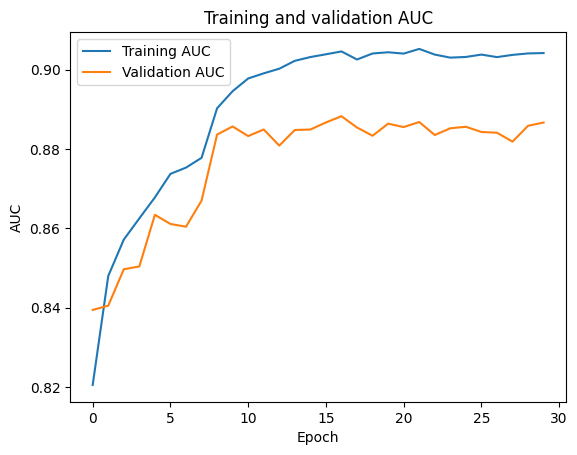

In [16]:
# Plot the training and validation loss
plt.plot(history.history['AUC'], label='Training AUC')
plt.plot(history.history['val_AUC'], label='Validation AUC')
plt.title('Training and validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

In [17]:
multi_gpu_model.save('DenseNet121_last_epoch.keras') 

In [6]:
from sklearn.metrics import roc_auc_score
import numpy as np

# Smaller batch size to fit within memory constraints
batch_size = 512

# Adjust the test generator with the new batch size
test_generator = ImageDataGenerator(
    preprocessing_function=preprocess_image
).flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col='full_path',
    y_col=labels,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size,
    shuffle=False  # Ensure data order is consistent
)



Found 23573 validated image filenames.


In [9]:
def ROC_AUC (multi_gpu_model):
    # Initialize arrays to store predictions and true labels
    y_preds = []
    y_trues = []

    # Iterate over the test generator and collect predictions
    for _ in range(len(test_generator)):
        x_batch, y_batch = next(test_generator)
        y_pred_batch = multi_gpu_model.predict(x_batch, verbose=0)
        y_preds.append(y_pred_batch)
        y_trues.append(y_batch)

    # Concatenate all batches together
    y_preds = np.concatenate(y_preds, axis=0)
    y_trues = np.concatenate(y_trues, axis=0)

    # Extract class labels from the dataframe columns
    class_labels = test_df[labels].columns

    # Compute the ROC AUC score for each class
    roc_auc_scores = {}
    for i, label in enumerate(class_labels):
        auc = roc_auc_score(y_trues[:, i], y_preds[:, i])
        roc_auc_scores[label] = auc

    # Print the ROC AUC scores
    for label, auc in roc_auc_scores.items():
        print(f"ROC AUC Score for {label}: {auc:.4f}")

    # Calculate and print the average ROC AUC score
    average_roc_auc = np.mean(list(roc_auc_scores.values()))
    print(f"Average ROC AUC Score: {average_roc_auc:.4f}")

In [20]:
ROC_AUC(multi_gpu_model)
multi_gpu_model=0

ROC AUC Score for Atelectasis: 0.8257
ROC AUC Score for Consolidation: 0.8113
ROC AUC Score for Infiltration: 0.7151
ROC AUC Score for Pneumothorax: 0.8921
ROC AUC Score for Edema: 0.8946
ROC AUC Score for Emphysema: 0.9163
ROC AUC Score for Fibrosis: 0.8300
ROC AUC Score for Effusion: 0.8886
ROC AUC Score for Pneumonia: 0.7686
ROC AUC Score for Pleural_Thickening: 0.7985
ROC AUC Score for Cardiomegaly: 0.9083
ROC AUC Score for Nodule: 0.7775
ROC AUC Score for Mass: 0.8644
ROC AUC Score for Hernia: 0.9414
Average ROC AUC Score: 0.8452


In [10]:
model_train_loss = load_model('/kaggle/input/good-and-last/keras/good-and-last/1/DenseNet121_train_loss (1).keras')
ROC_AUC(model_train_loss)
model_train_loss=0

ROC AUC Score for Atelectasis: 0.8232
ROC AUC Score for Consolidation: 0.8120
ROC AUC Score for Infiltration: 0.7171
ROC AUC Score for Pneumothorax: 0.8928
ROC AUC Score for Edema: 0.8952
ROC AUC Score for Emphysema: 0.9151
ROC AUC Score for Fibrosis: 0.8325
ROC AUC Score for Effusion: 0.8881
ROC AUC Score for Pneumonia: 0.7738
ROC AUC Score for Pleural_Thickening: 0.8028
ROC AUC Score for Cardiomegaly: 0.9100
ROC AUC Score for Nodule: 0.7789
ROC AUC Score for Mass: 0.8630
ROC AUC Score for Hernia: 0.9505
Average ROC AUC Score: 0.8468


In [13]:
model_train_AUC = load_model('/kaggle/input/good-and-last/keras/good-and-last/1/DenseNet121_train_AUC (1).keras')
ROC_AUC(model_train_AUC)
model_train_AUC=0

ROC AUC Score for Atelectasis: 0.8230
ROC AUC Score for Consolidation: 0.8121
ROC AUC Score for Infiltration: 0.7171
ROC AUC Score for Pneumothorax: 0.8927
ROC AUC Score for Edema: 0.8952
ROC AUC Score for Emphysema: 0.9151
ROC AUC Score for Fibrosis: 0.8322
ROC AUC Score for Effusion: 0.8882
ROC AUC Score for Pneumonia: 0.7741
ROC AUC Score for Pleural_Thickening: 0.8026
ROC AUC Score for Cardiomegaly: 0.9099
ROC AUC Score for Nodule: 0.7789
ROC AUC Score for Mass: 0.8629
ROC AUC Score for Hernia: 0.9503
Average ROC AUC Score: 0.8467


In [11]:
model_val_loss = load_model('/kaggle/input/good-and-last/keras/good-and-last/1/DenseNet121_val_loss (1).keras')
ROC_AUC(model_val_loss)
model_val_loss=0

ROC AUC Score for Atelectasis: 0.8216
ROC AUC Score for Consolidation: 0.8112
ROC AUC Score for Infiltration: 0.7154
ROC AUC Score for Pneumothorax: 0.8922
ROC AUC Score for Edema: 0.8955
ROC AUC Score for Emphysema: 0.9111
ROC AUC Score for Fibrosis: 0.8299
ROC AUC Score for Effusion: 0.8880
ROC AUC Score for Pneumonia: 0.7763
ROC AUC Score for Pleural_Thickening: 0.7998
ROC AUC Score for Cardiomegaly: 0.9092
ROC AUC Score for Nodule: 0.7769
ROC AUC Score for Mass: 0.8582
ROC AUC Score for Hernia: 0.9471
Average ROC AUC Score: 0.8452


In [12]:
model_val_AUC = load_model('/kaggle/input/good-and-last/keras/good-and-last/1/DenseNet121_val_AUC (1).keras')
ROC_AUC(model_val_AUC)
model_val_AUC=0

ROC AUC Score for Atelectasis: 0.8230
ROC AUC Score for Consolidation: 0.8121
ROC AUC Score for Infiltration: 0.7171
ROC AUC Score for Pneumothorax: 0.8927
ROC AUC Score for Edema: 0.8952
ROC AUC Score for Emphysema: 0.9151
ROC AUC Score for Fibrosis: 0.8322
ROC AUC Score for Effusion: 0.8882
ROC AUC Score for Pneumonia: 0.7741
ROC AUC Score for Pleural_Thickening: 0.8026
ROC AUC Score for Cardiomegaly: 0.9099
ROC AUC Score for Nodule: 0.7789
ROC AUC Score for Mass: 0.8629
ROC AUC Score for Hernia: 0.9503
Average ROC AUC Score: 0.8467


# Meetrices

In [7]:
model_val_AUC = load_model('/kaggle/input/good-and-last/keras/good-and-last/1/DenseNet121_val_AUC (1).keras')

In [10]:
from sklearn.metrics import roc_auc_score
import numpy as np

# Smaller batch size to fit within memory constraints
batch_size = 512

# Adjust the test generator with the new batch size
test_generator = ImageDataGenerator(
    preprocessing_function=preprocess_image
).flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col='full_path',
    y_col=labels,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size,
    shuffle=False  # Ensure data order is consistent
)


Found 23573 validated image filenames.


In [12]:
# Initialize arrays to store predictions and true labels
y_preds = []
y_trues = []

In [13]:
# Iterate over the test generator and collect predictions
for _ in range(len(test_generator)):
    x_batch, y_batch = next(test_generator)
    y_pred_batch = model_val_AUC.predict(x_batch, verbose =0)
    y_preds.append(y_pred_batch)
    y_trues.append(y_batch)

In [15]:
# Compute the ROC AUC score for each class
roc_auc_scores = {}
for i, label in enumerate(class_labels):
    auc = roc_auc_score(y_trues[:, i], y_preds[:, i])
    roc_auc_scores[label] = auc

# Print the ROC AUC scores
for label, auc in roc_auc_scores.items():
    print(f"ROC AUC Score for {label}: {auc:.4f}")

# Calculate and print the average ROC AUC score
average_roc_auc = np.mean(list(roc_auc_scores.values()))
print(f"Average ROC AUC Score: {average_roc_auc:.4f}")

ROC AUC Score for Atelectasis: 0.8230
ROC AUC Score for Consolidation: 0.8121
ROC AUC Score for Infiltration: 0.7171
ROC AUC Score for Pneumothorax: 0.8927
ROC AUC Score for Edema: 0.8952
ROC AUC Score for Emphysema: 0.9151
ROC AUC Score for Fibrosis: 0.8322
ROC AUC Score for Effusion: 0.8882
ROC AUC Score for Pneumonia: 0.7741
ROC AUC Score for Pleural_Thickening: 0.8026
ROC AUC Score for Cardiomegaly: 0.9099
ROC AUC Score for Nodule: 0.7789
ROC AUC Score for Mass: 0.8629
ROC AUC Score for Hernia: 0.9503
Average ROC AUC Score: 0.8467


Micro-Average ROC AUC Score: 0.8876


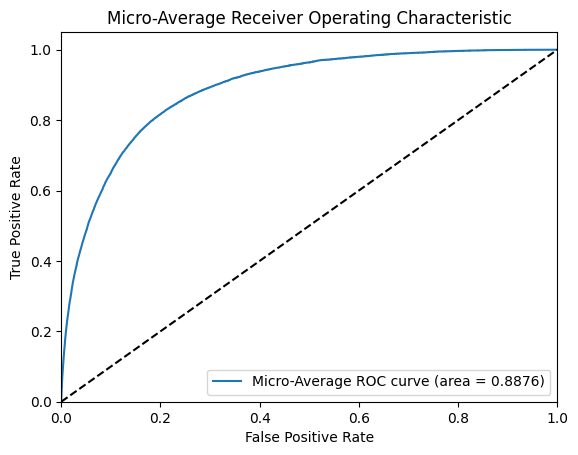

In [69]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Compute the ROC AUC score (micro-average)
roc_auc_micro = roc_auc_score(y_trues, y_preds, average='micro')
print(f"Micro-Average ROC AUC Score: {roc_auc_micro:.4f}")

# Compute the ROC curve (micro-average)
fpr, tpr, _ = roc_curve(y_trues.ravel(), y_preds.ravel())

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'Micro-Average ROC curve (area = {roc_auc_micro:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Average Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Save the figure
plt.savefig('Micro-Average-ROC.png', bbox_inches='tight')

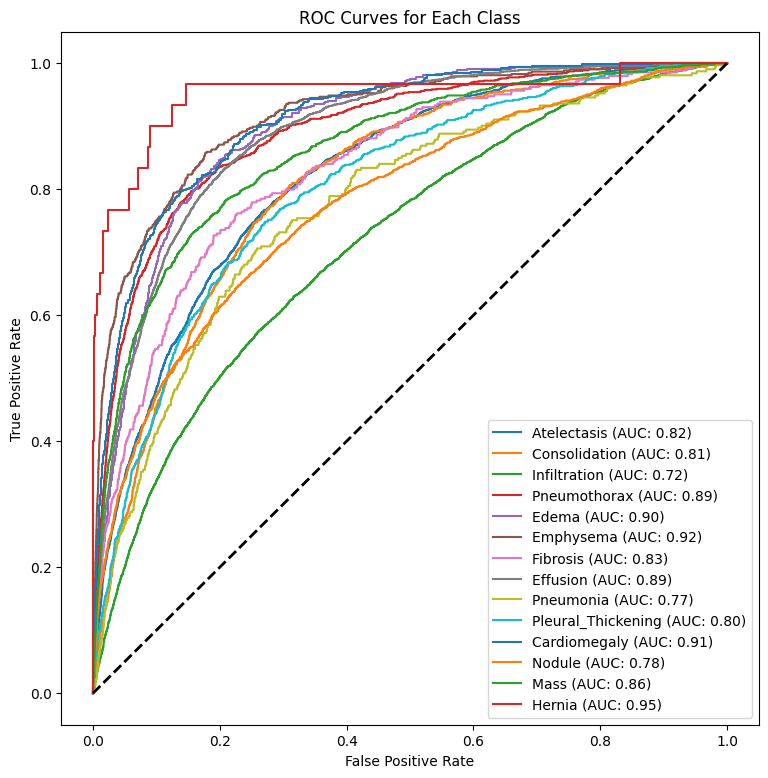

In [64]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_trues and y_preds are already defined
# class_labels should be a list of class names

# Plot ROC curves for each class
fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(class_labels):
    fpr, tpr, thresholds = roc_curve(y_trues[:, idx], y_preds[:, idx])
    auc_score = auc(fpr, tpr)
    c_ax.plot(fpr, tpr, label=f'{c_label} (AUC: {auc_score:.2f})')

# Plotting the diagonal line
c_ax.plot([0, 1], [0, 1], 'k--', lw=2)

# Set plot labels and title
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
c_ax.set_title('ROC Curves for Each Class')
c_ax.legend(loc='best')

# Save the figure
fig.savefig('ROC Curves.png')
plt.show()


In [62]:
!rm -rf /kaggle/working/*

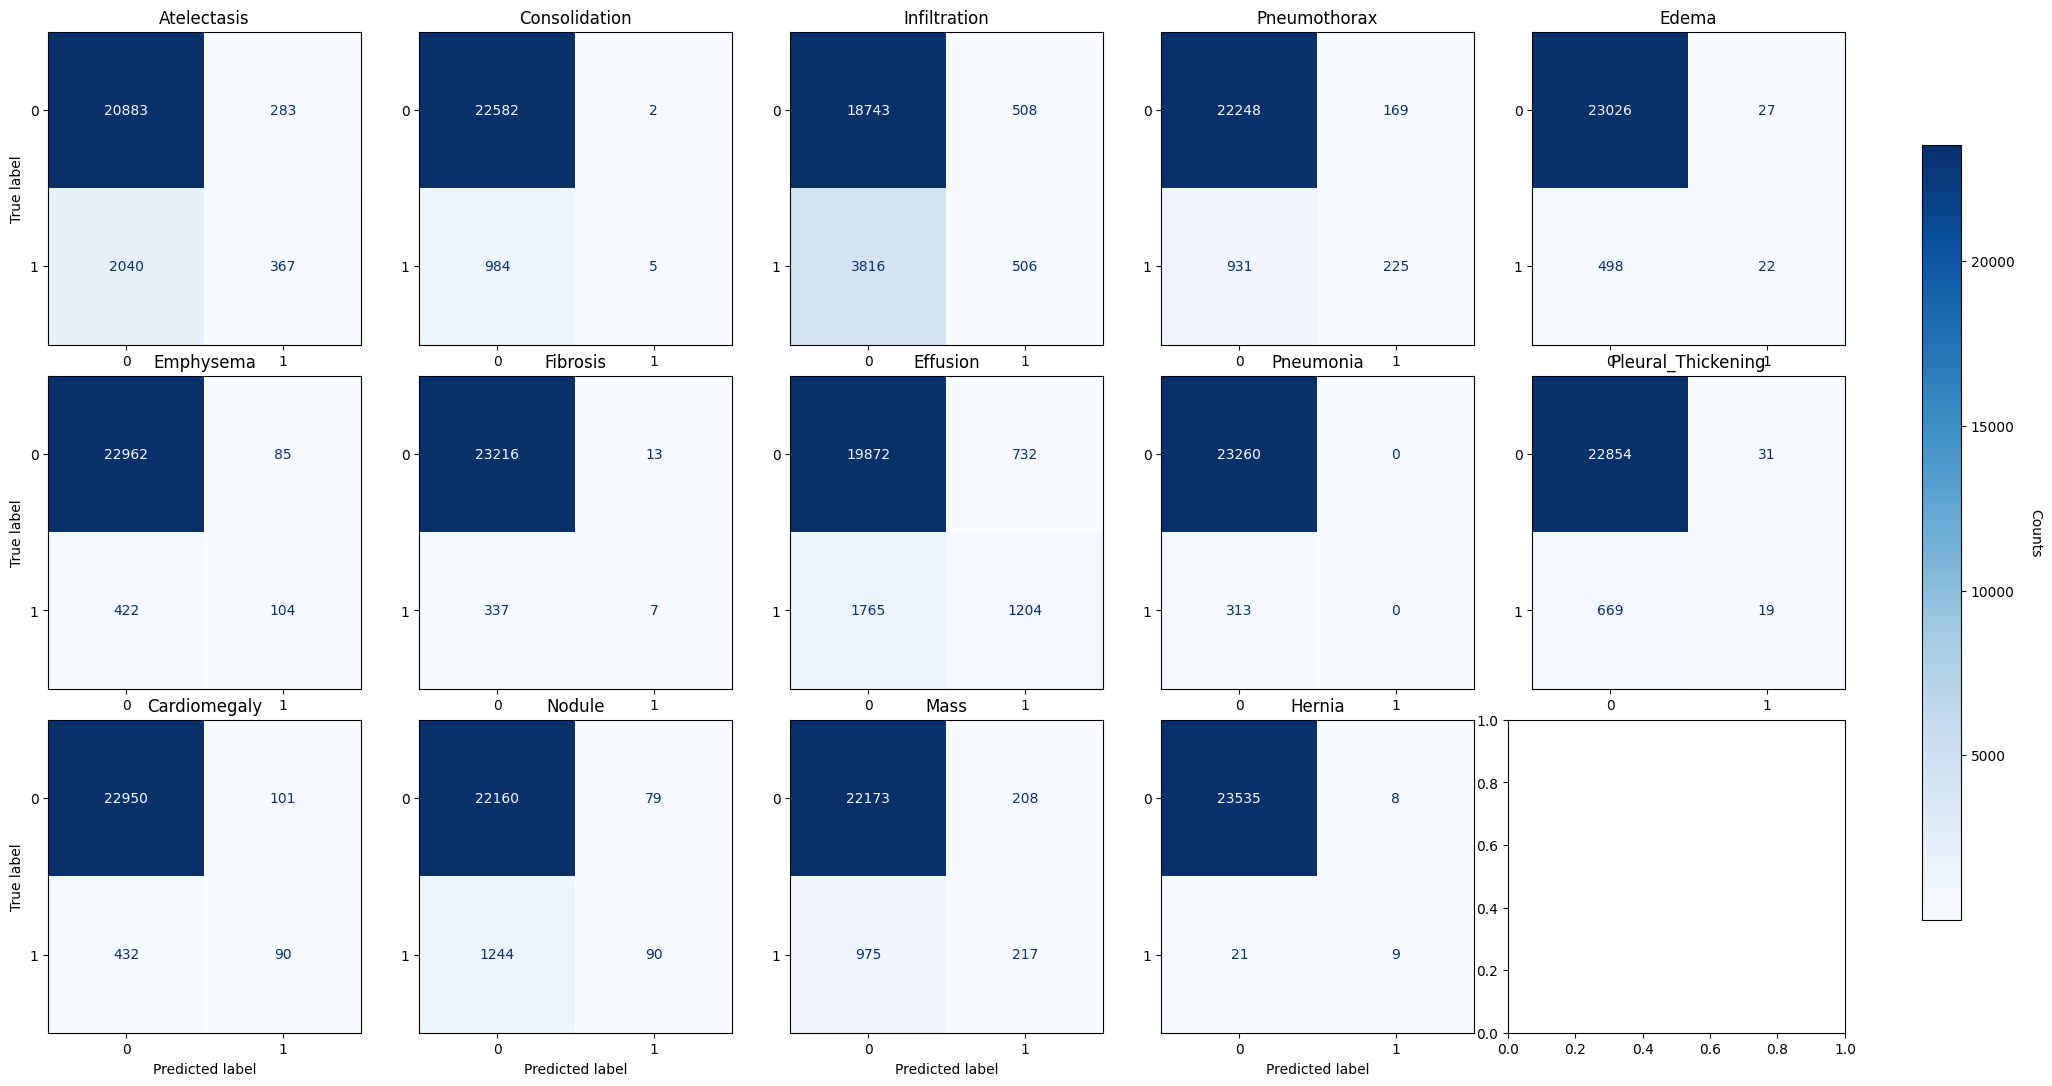

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix
import matplotlib.pyplot as plt

# Assume y_preds and y_trues are already defined as above
y_pred = (y_preds > 0.5).astype(int)
y_true = y_trues

# Calculate the confusion matrix for each label
cm = multilabel_confusion_matrix(y_true, y_pred)

# Set the figure size and create subplots
f, axes = plt.subplots(3, 5, figsize=(25, 13))
axes = axes.ravel()

# Loop through each class label
for i in range(len(labels)):
    # Create the confusion matrix display
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true[:, i], y_pred[:, i]),
                                  display_labels=[0, 1])  # Assuming binary labels (0, 1)
    # Set the color map to 'Blues' and float the colorbar
    disp.plot(ax=axes[i], values_format='d', cmap='Blues')  # Change to '.2f' for two decimal places
    disp.ax_.set_title(labels[i])

    # Adjust axis labels
    if i < 10:
        disp.ax_.set_xlabel('')
    if i % 5 != 0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()  # Remove the individual colorbar

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.10, hspace=0.1)

# Add a single, shared colorbar
cbar = f.colorbar(disp.im_, ax=axes, location='right', fraction=0.02, pad=0.04)
cbar.ax.set_ylabel('Counts', rotation=270, labelpad=20)

# Save the plot as a PNG file
plt.savefig('confusion_matrix.png', bbox_inches='tight')


In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
y_pred_classes = np.where(y_preds > 0.5, 1, 0)  # Assuming binary classification


In [38]:
# Initialize dictionaries to hold scores per class
precision_scores = {}
recall_scores = {}
f1_scores = {}
accuracy_scores = {}

# Extract class labels from the dataframe columns
class_labels = test_df[labels].columns

for i, label in enumerate(class_labels):
    precision = precision_score(y_trues[:, i], y_pred_classes[:, i])
    recall = recall_score(y_trues[:, i], y_pred_classes[:, i])
    f1 = f1_score(y_trues[:, i], y_pred_classes[:, i])
    accuracy = accuracy_score(y_trues[:, i], y_pred_classes[:, i])
    
    # Store the scores
    precision_scores[label] = precision
    recall_scores[label] = recall
    f1_scores[label] = f1
    accuracy_scores[label] = accuracy

# Print the metrics for each class
for label in class_labels:
    print(f"{label} - Precision: {precision_scores[label]:.4f}, Recall: {recall_scores[label]:.4f}, F1 Score: {f1_scores[label]:.4f}, Accuracy: {accuracy_scores[label]:.4f}")


Atelectasis - Precision: 0.5646, Recall: 0.1525, F1 Score: 0.2401, Accuracy: 0.9015
Consolidation - Precision: 0.7143, Recall: 0.0051, F1 Score: 0.0100, Accuracy: 0.9582
Infiltration - Precision: 0.4990, Recall: 0.1171, F1 Score: 0.1897, Accuracy: 0.8166
Pneumothorax - Precision: 0.5711, Recall: 0.1946, F1 Score: 0.2903, Accuracy: 0.9533
Edema - Precision: 0.4490, Recall: 0.0423, F1 Score: 0.0773, Accuracy: 0.9777
Emphysema - Precision: 0.5503, Recall: 0.1977, F1 Score: 0.2909, Accuracy: 0.9785
Fibrosis - Precision: 0.3500, Recall: 0.0203, F1 Score: 0.0385, Accuracy: 0.9852
Effusion - Precision: 0.6219, Recall: 0.4055, F1 Score: 0.4909, Accuracy: 0.8941
Pneumonia - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, Accuracy: 0.9867
Pleural_Thickening - Precision: 0.3800, Recall: 0.0276, F1 Score: 0.0515, Accuracy: 0.9703
Cardiomegaly - Precision: 0.4712, Recall: 0.1724, F1 Score: 0.2525, Accuracy: 0.9774
Nodule - Precision: 0.5325, Recall: 0.0675, F1 Score: 0.1198, Accuracy: 0.9439
M

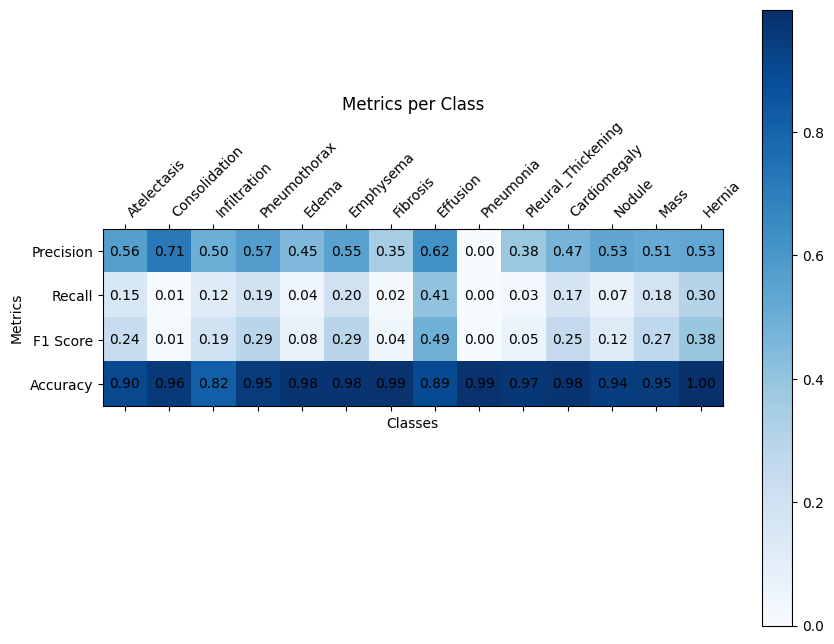

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming precision_scores, recall_scores, f1_scores, and accuracy_scores are already calculated

# Extract class labels from the dictionary keys
class_labels = list(precision_scores.keys())

# Combine all metrics into a single matrix
metrics_matrix = np.array([
    list(precision_scores.values()),
    list(recall_scores.values()),
    list(f1_scores.values()),
    list(accuracy_scores.values())
])

# Define the metric names
metric_names = ['Precision', 'Recall', 'F1 Score', 'Accuracy']

# Plotting the metrics in a matrix-style grid
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(metrics_matrix, cmap='Blues')

# Add color bar
plt.colorbar(cax)

# Set axis labels
ax.set_xticks(np.arange(len(class_labels)))
ax.set_yticks(np.arange(len(metric_names)))

# Label the axes with class names and metric names
ax.set_xticklabels(class_labels, rotation=45, ha="left")
ax.set_yticklabels(metric_names)

# Loop over data dimensions and create text annotations
for i in range(len(metric_names)):
    for j in range(len(class_labels)):
        ax.text(j, i, f'{metrics_matrix[i, j]:.2f}', ha='center', va='center', color='black')

# Set titles and layout
plt.xlabel('Classes')
plt.ylabel('Metrics')
plt.title('Metrics per Class')
fig.savefig('Metrics per Class.png')
plt.show()


In [31]:
avg_precision = np.mean(list(precision_scores.values()))
avg_recall = np.mean(list(recall_scores.values()))
avg_f1 = np.mean(list(f1_scores.values()))
avg_accuracy = np.mean(list(accuracy_scores.values()))

print(f"\nAverage Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f}")



Average Precision: 0.4817
Average Recall: 0.1346
Average F1 Score: 0.1931
Average Accuracy: 0.9494


In [32]:
roc_auc_scores = {}
for i, label in enumerate(class_labels):
    auc = roc_auc_score(y_trues[:, i], y_preds[:, i])
    roc_auc_scores[label] = auc

# Print the ROC AUC scores
for label, auc in roc_auc_scores.items():
    print(f"ROC AUC Score for {label}: {auc:.4f}")

# Calculate and print the average ROC AUC score
average_roc_auc = np.mean(list(roc_auc_scores.values()))
print(f"Average ROC AUC Score: {average_roc_auc:.4f}")


ROC AUC Score for Atelectasis: 0.8230
ROC AUC Score for Consolidation: 0.8121
ROC AUC Score for Infiltration: 0.7171
ROC AUC Score for Pneumothorax: 0.8927
ROC AUC Score for Edema: 0.8952
ROC AUC Score for Emphysema: 0.9151
ROC AUC Score for Fibrosis: 0.8322
ROC AUC Score for Effusion: 0.8882
ROC AUC Score for Pneumonia: 0.7741
ROC AUC Score for Pleural_Thickening: 0.8026
ROC AUC Score for Cardiomegaly: 0.9099
ROC AUC Score for Nodule: 0.7789
ROC AUC Score for Mass: 0.8629
ROC AUC Score for Hernia: 0.9503
Average ROC AUC Score: 0.8467
